In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Training
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [34]:
Data = pd.read_csv("Life-Expectancy-Data-Updated.csv")
print(Data.columns)
print(np.unique(Data["Country"]))

Index(['Country', 'Region', 'Year', 'Infant_deaths', 'Under_five_deaths',
       'Adult_mortality', 'Alcohol_consumption', 'Hepatitis_B', 'Measles',
       'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
       'Population_mln', 'Thinness_ten_nineteen_years',
       'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed',
       'Economy_status_Developing', 'Life_expectancy'],
      dtype='object')
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas, The'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil'
 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Comoros' 'Congo, Dem. Rep.' 'Congo, Rep.'
 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 'Denmark' 'Djibouti

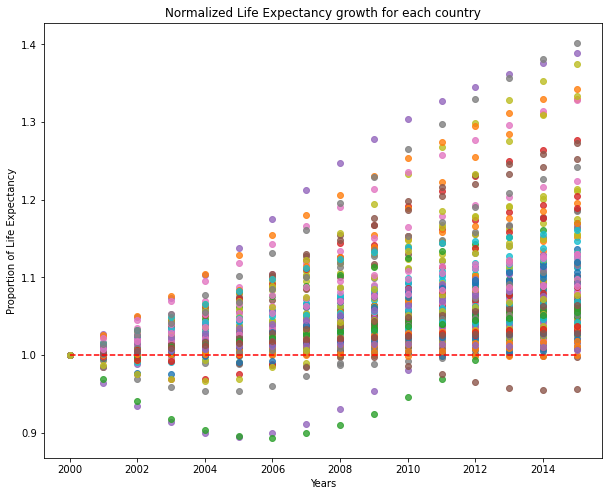

In [40]:
countries = np.unique(Data["Country"])

fig = plt.figure(figsize=(10,8))

for cont in countries:
    life_exp = Data[Data["Country"]==cont]["Life_expectancy"].values
    years = Data[Data["Country"]==cont]["Year"].values
    year2000ind = np.where(years == min(years))  # for the purpose of separate cases where life exp is between 50-60, 60-70, 70-80, and so on.
    life_exp_2000 = life_exp[year2000ind][0]
    plt.scatter(years,life_exp/life_exp_2000, label=cont, alpha=0.8)
plt.plot(np.arange(2000,2016,1),np.ones(16),"--r")
plt.title("Normalized Life Expectancy growth for each country")
plt.ylabel("Proportion of Life Expectancy")
plt.xlabel("Years")
plt.show()

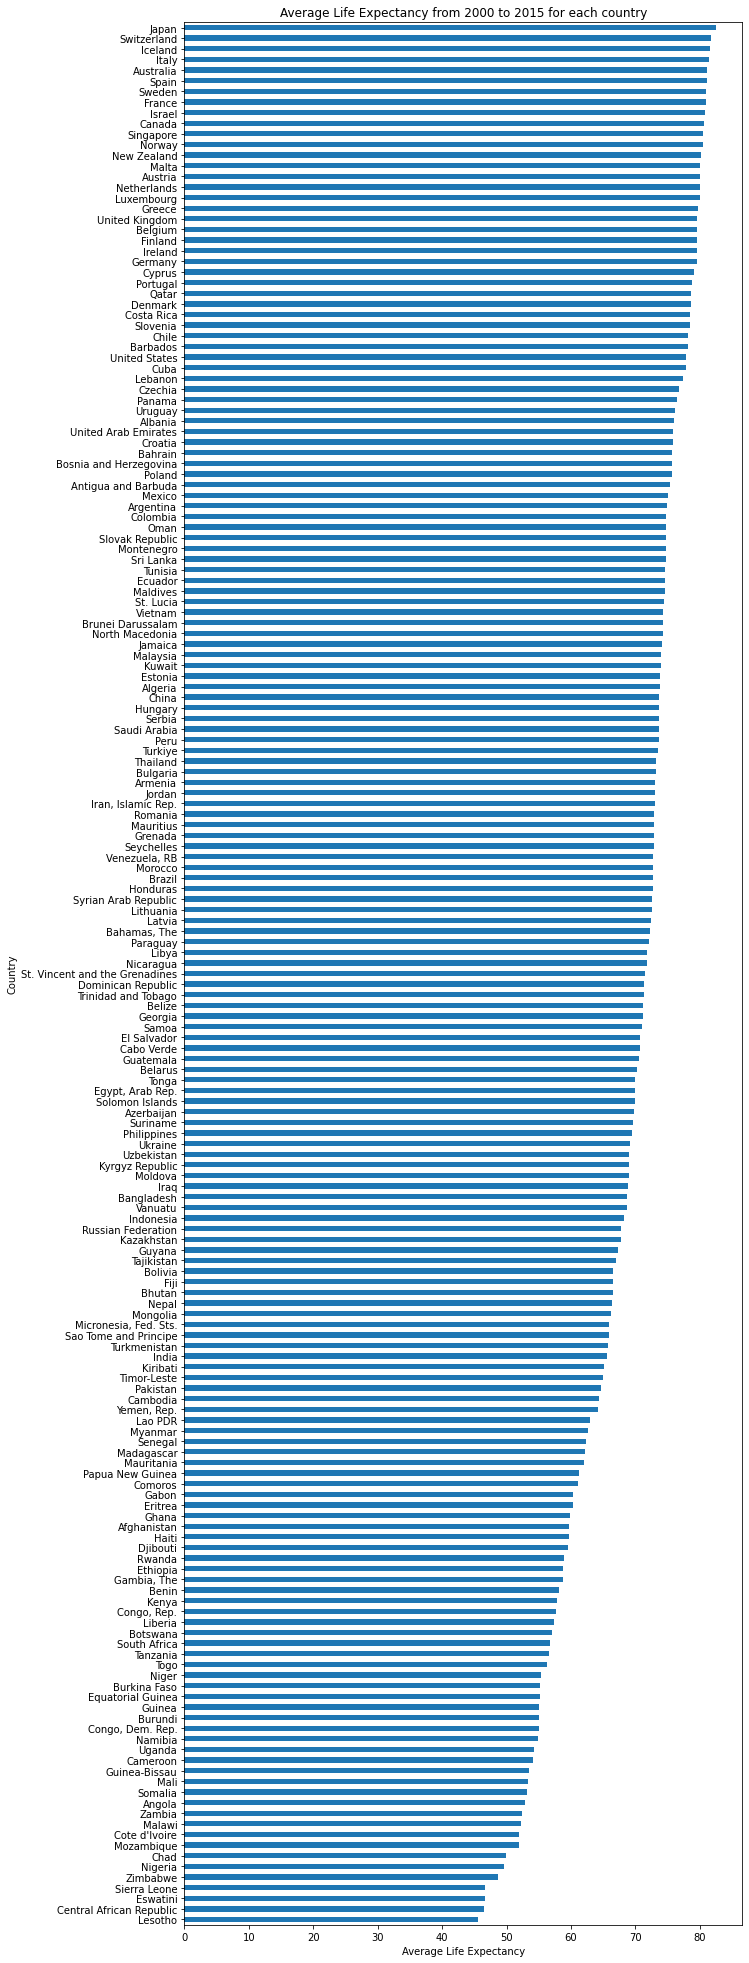

In [45]:
Data.groupby("Country")["Life_expectancy"].mean().sort_values().plot(kind="barh", 
                                                                      title="Average Life Expectancy from 2000 to 2015 for each country", 
                                                                      xlabel="Average Life Expectancy",
                                                                      figsize=(10,35))
plt.show()

# ***Correlation Analysis***

**Title:** *Life Expectancy vs GDP*

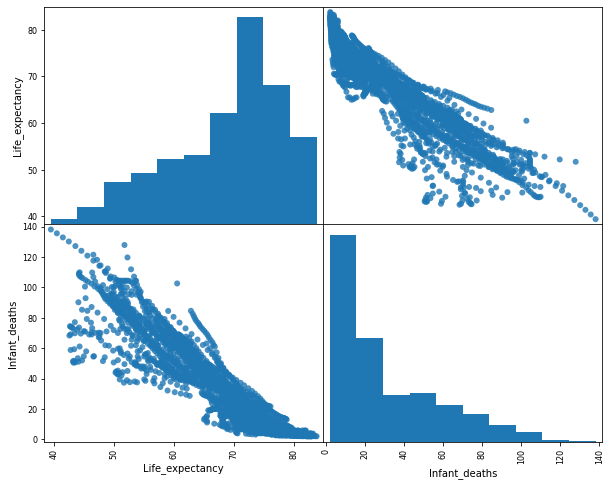

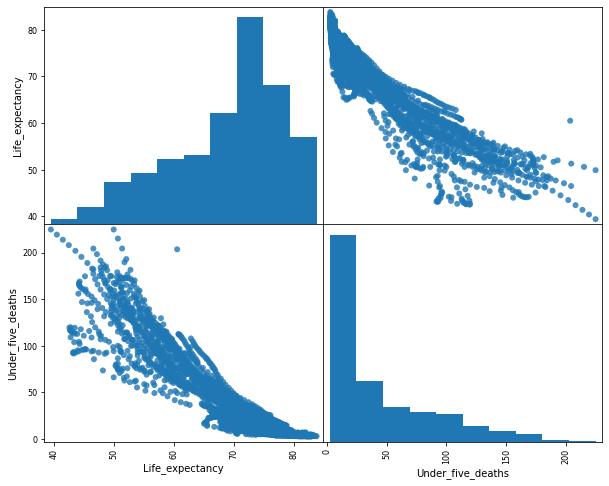

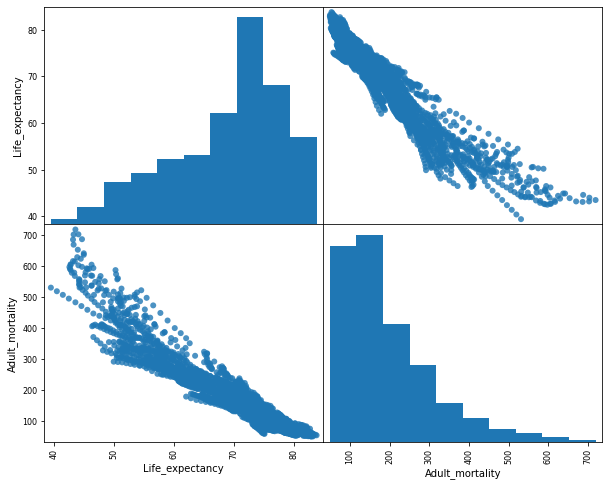

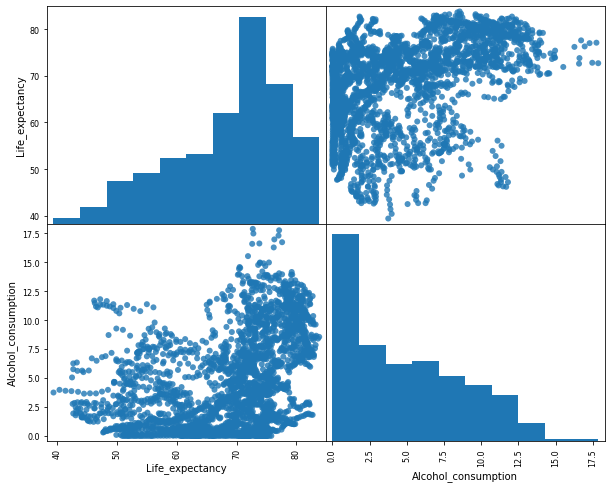

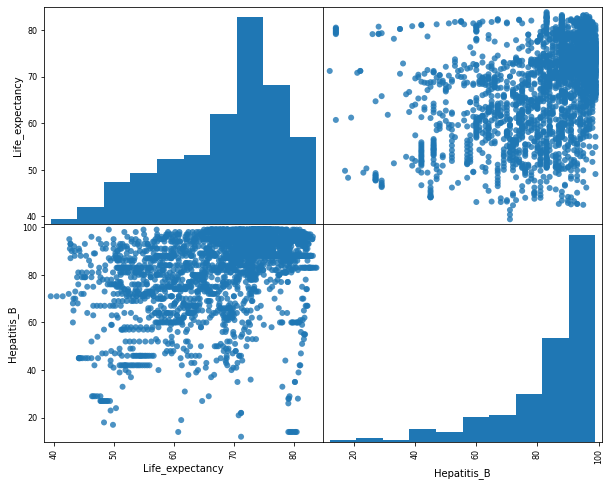

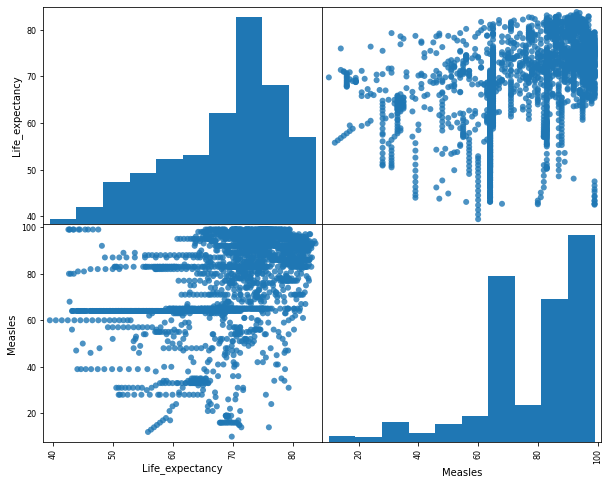

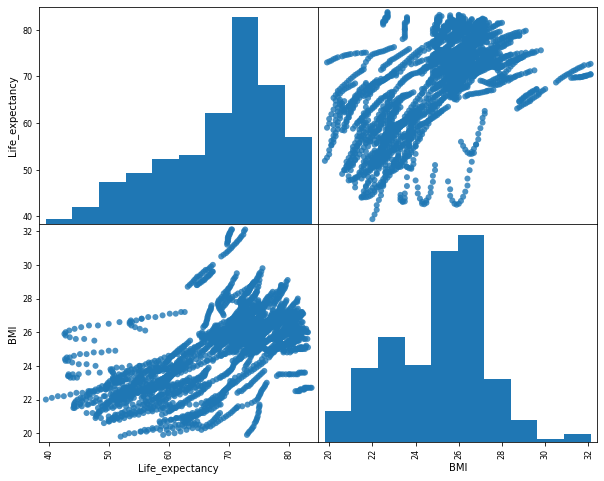

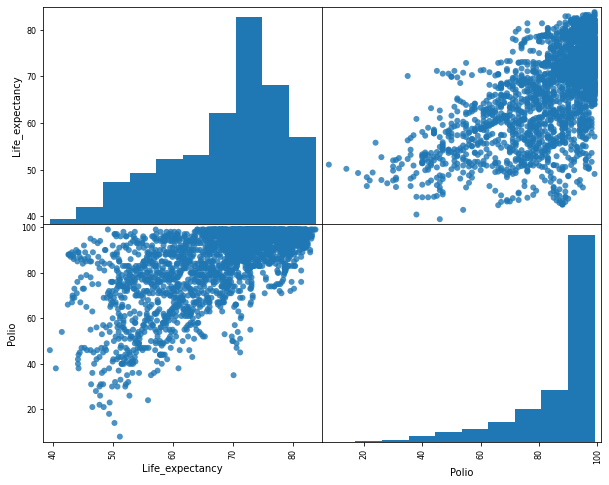

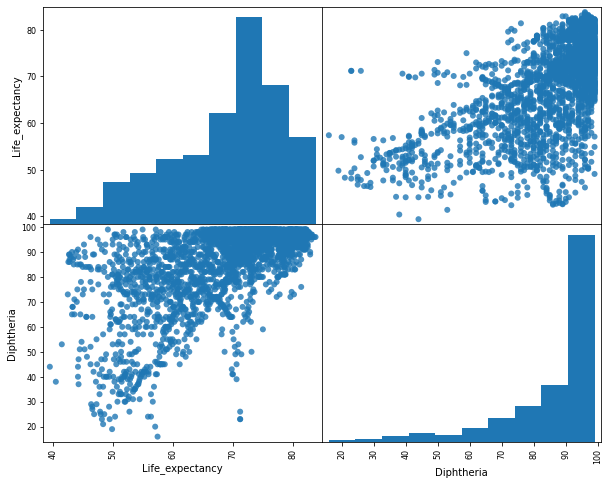

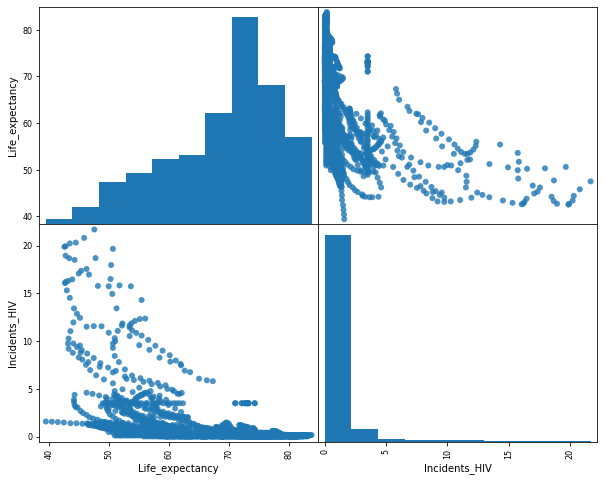

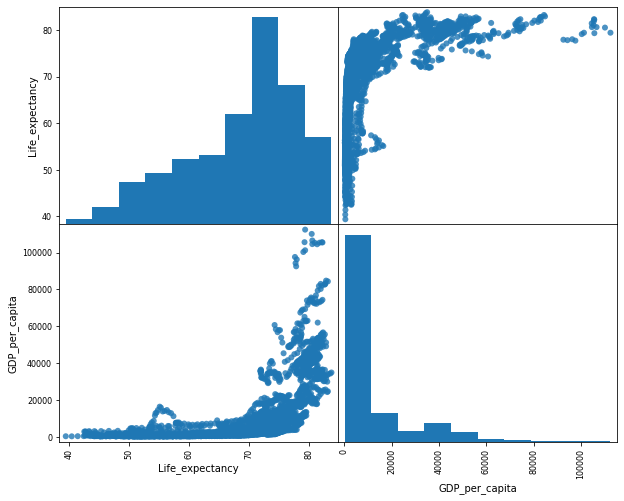

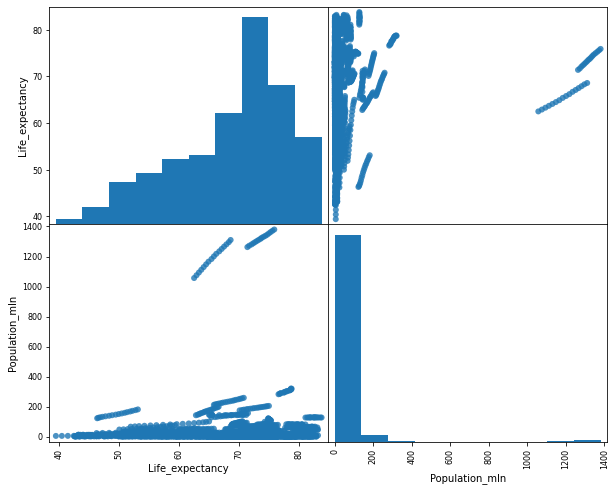

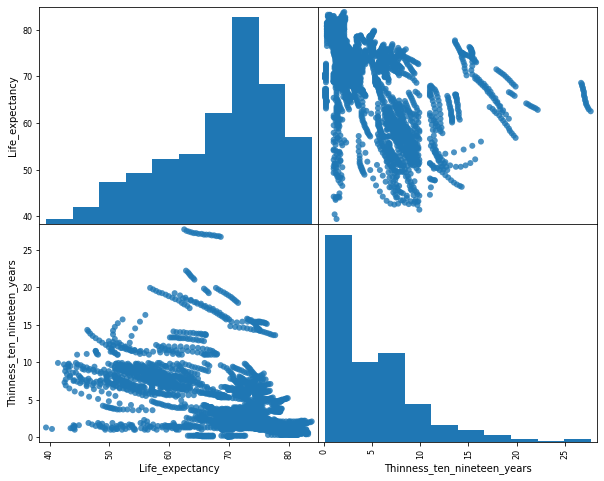

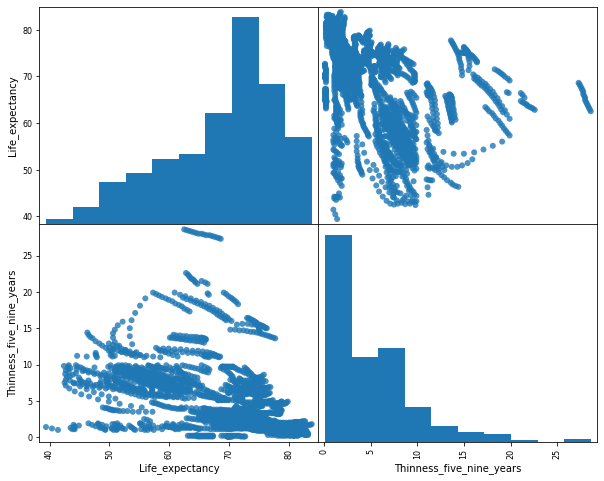

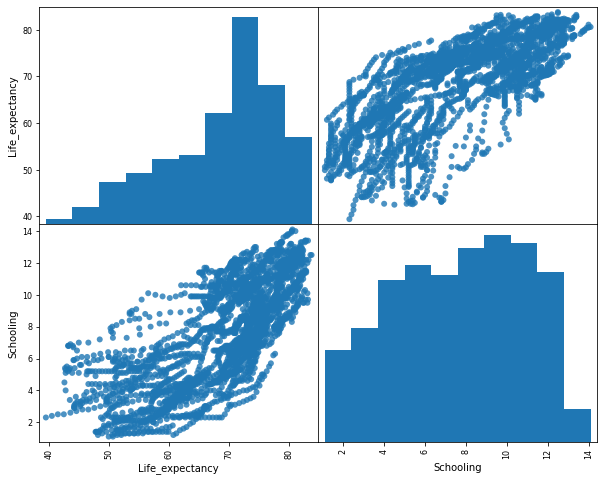

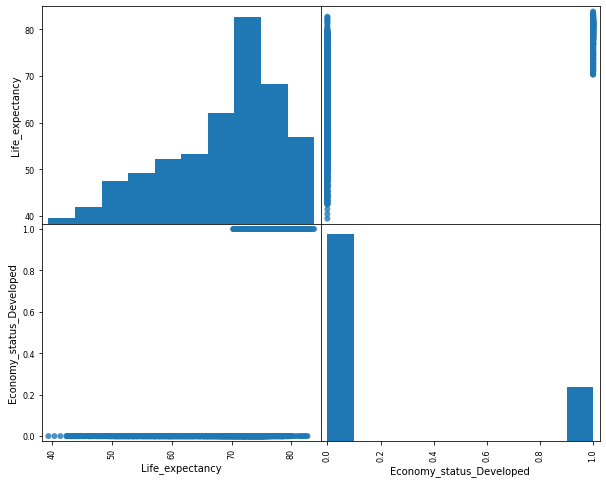

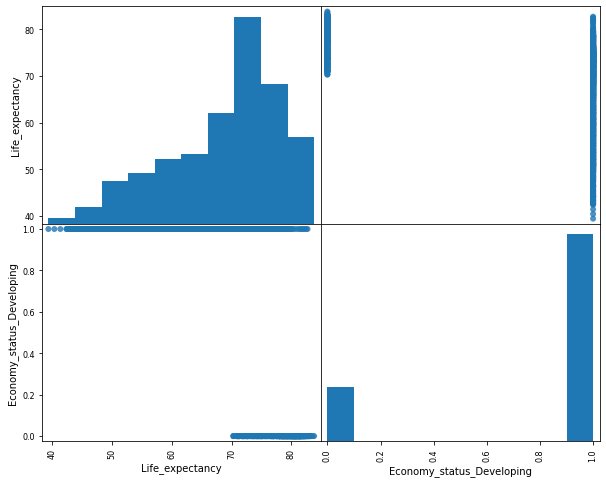

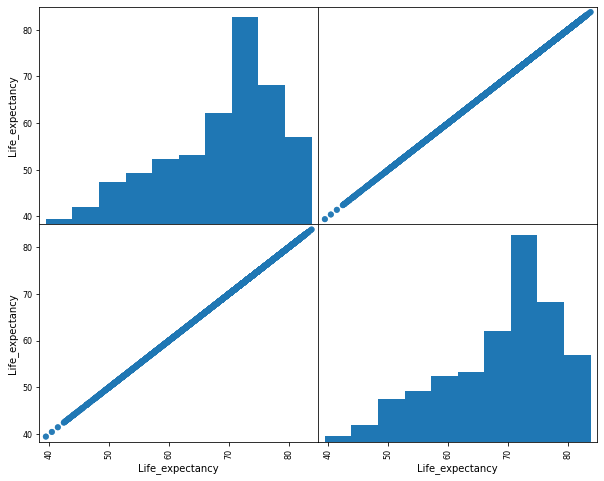

In [64]:
for col in Data.columns.values[3:]:
    pd.plotting.scatter_matrix(Data[['Life_expectancy', col]],figsize=(10,8),alpha=0.8,marker="o")
plt.show()

# *Overall Correlationship between 'Life Expectancy' and others*

In [72]:
overall = Data.drop(["Country","Region"], axis=1).corr()["Life_expectancy"]
print(overall)
overall_v = np.array(overall.values)
overall_vals = np.array(abs(overall.values))
overall_keys = np.array(overall.keys())
temp_sort = np.sort(overall_vals)

# top_5_keys = [overall_keys[np.where(overall_vals==ind)[0][0]] for ind in temp_sort[-6:-1]]
top_5_vals = overall[top_5_keys]
print("\n", "Top 5 features and scores according to correlation")
# print(top_5_keys[::-1])
print(top_5_vals[::-1])

Year                           0.174359
Infant_deaths                 -0.920032
Under_five_deaths             -0.920419
Adult_mortality               -0.945360
Alcohol_consumption            0.399159
Hepatitis_B                    0.417804
Measles                        0.490019
BMI                            0.598423
Polio                          0.641217
Diphtheria                     0.627541
Incidents_HIV                 -0.553027
GDP_per_capita                 0.583090
Population_mln                 0.026298
Thinness_ten_nineteen_years   -0.467824
Thinness_five_nine_years      -0.458166
Schooling                      0.732484
Economy_status_Developed       0.523791
Economy_status_Developing     -0.523791
Life_expectancy                1.000000
Name: Life_expectancy, dtype: float64

 Top 5 features and scores according to correlation
Adult_mortality     -0.945360
Under_five_deaths   -0.920419
Infant_deaths       -0.920032
Schooling            0.732484
Polio                0.641217

# ***Training***

In [29]:
# Add colume "LiveLong" as an indication showing the data has higher life expectancy than 
# the global average of life expectancy.
mean_ = Data["Life expectancy "].mean()
Data["LiveLong"] = Data["Life expectancy "].values > mean_

y = Data["LiveLong"]
X = Data.drop(["LiveLong","Life expectancy "], axis=1)

# separate the train and the test datasets
X_train, X_test, y_train_, y_test_ = train_test_split(X, y, test_size=0.1, random_state=42)



In [32]:
for cont in countries:
    life_exp = Data[Data["Country"]==cont]["Life expectancy "].values
    years = Data[Data["Country"]==cont]["Year"].values
    # for each country
    X = Data[Data["Country"]==cont].drop(["Life expectancy ","Year"], axis=1)
X


,Country,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,LiveLong
2872,Zimbabwe,False,336.0,22,4.482,0.000000,87.0,0,31.8,32,...,6.158667,87.0,6.2,118.693830,15777451.0,5.6,5.5,0.507,10.3,False
2873,Zimbabwe,False,371.0,23,6.500,10.822595,91.0,0,31.3,34,...,6.440000,91.0,6.3,127.474620,15411675.0,5.9,5.7,0.498,10.3,False
2874,Zimbabwe,False,399.0,25,6.390,10.666707,95.0,0,3.8,36,...,6.880000,95.0,6.8,111.227396,155456.0,6.2,6.0,0.488,10.4,False
2875,Zimbabwe,False,429.0,26,6.090,92.602336,97.0,0,3.3,39,...,6.690000,95.0,8.8,955.648466,1471826.0,6.5,6.4,0.464,9.8,False
2876,Zimbabwe,False,464.0,28,6.000,63.750530,94.0,0,29.9,42,...,6.310000,93.0,13.3,839.927936,14386649.0,6.8,6.7,0.452,10.1,False
2877,Zimbabwe,False,527.0,29,5.210,53.308581,9.0,9696,29.4,44,...,5.370000,89.0,15.7,713.635620,1486317.0,7.1,7.0,0.436,10.0,False
2878,Zimbabwe,False,587.0,30,4.640,1.040021,73.0,853,29.0,45,...,6.260000,73.0,18.1,65.824121,1381599.0,7.5,7.4,0.419,9.9,False
2879,Zimbabwe,False,632.0,30,3.560,20.843429,75.0,0,28.6,46,...,4.960000,75.0,20.5,325.678573,13558469.0,7.8,7.8,0.421,9.7,False
2880,Zimbabwe,False,67.0,29,3.880,29.814566,72.0,242,28.2,46,...,4.470000,73.0,23.7,396.998217,1332999.0,8.2,8.2,0.414,9.6,False
2881,Zimbabwe,False,7.0,28,4.570,34.262169,68.0,212,27.9,45,...,5.120000,7.0,26.8,414.796232,13124267.0,8.6,8.6,0.408,9.5,False
